In [71]:
from morfeus.conformer import ConformerEnsemble
from pathlib import Path
import stk
import pymongo
from morfeus import BuriedVolume, read_xyz
import os
from photocat_database.calculators.Optimise_ON import ETKDG_constaint
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [72]:

client = "mongodb://localhost:27017/"
client = pymongo.MongoClient(client)
inchikey_photo_cat = "UYBPBNGMIRHRMW-KTMFPKCZSA-N"
db_mol_list = ["constructed_photocat_Z","constructed_photocat_E","constructed_photocat_Z_ON","constructed_photocat_E_ON"]
db_mol= "constructed_photocat_Z"
db_constructed = stk.ConstructedMoleculeMongoDb(
    client,
    database=db_mol,
)
constructed_molecule = db_constructed.get(
    {"InChIKey": inchikey_photo_cat}
)
collection = client[db_mol]['crest']
data_crest = collection.find_one({"InChIKey":inchikey_photo_cat})
data_crest['crest_conformers']
original_path = "/media/mohammed/Work/Work/photo_switch/src/photocat_database"
crest_path = Path(original_path) / data_crest['crest_conformers']
print(crest_path.exists())
print('crest_path',data_crest['crest_conformers'])
ce = ConformerEnsemble.from_crest(crest_path.parent)
ce.sort()

True
crest_path data/constructed_photocat_Z/Crest/UYBPBNGMIRHRMW-KTMFPKCZSA-N/crest_conformers.xyz


ConformerEnsemble(157 conformers)

In [89]:
calculator = ETKDG_constaint()
oxygen_id, hydrogen_id = (
    calculator.get_atom_position_to_induce_constain_for_3bb(
        constructed_molecule
    )
)
for conformer in ce:
    elements, coordinates = ce.elements, conformer.coordinates
    bv = BuriedVolume(elements, coordinates, hydrogen_id[0]+1)
    conformer.properties['buried_volume_H1'] = bv.fraction_buried_volume
    bv = BuriedVolume(elements, coordinates, hydrogen_id[1]+1)
    conformer.properties['buried_volume_H2'] = bv.fraction_buried_volume


(array([ 8.,  2.,  3., 41., 36.,  7., 11.,  7.,  2.,  1.,  1.,  0.,  0.,
         0.,  3.,  0.,  0.,  3.,  0.,  1.,  0.,  0.,  2.,  5.,  6.,  0.,
         1.,  4.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,
         1.,  1.,  3.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([0.43314387, 0.43934973, 0.44555558, 0.45176144, 0.45796729,
        0.46417315, 0.47037901, 0.47658486, 0.48279072, 0.48899658,
        0.49520243, 0.50140829, 0.50761414, 0.51382   , 0.52002586,
        0.52623171, 0.53243757, 0.53864343, 0.54484928, 0.55105514,
        0.557261  , 0.56346685, 0.56967271, 0.57587856, 0.58208442,
        0.58829028, 0.59449613, 0.60070199, 0.60690785, 0.6131137 ,
        0.61931956, 0.62552541, 0.63173127, 0.63793713, 0.64414298,
        0.65034884, 0.6565547 , 0.66276055, 0.66896641, 0.67517227,
        0.68137812, 0.68758398, 0.69378983, 0.69999569, 0.70620155,
        0.7124074 , 0.71861326, 0.72481912, 0.73102497, 0.73723083,
        0.74343668]),
 <BarContainer

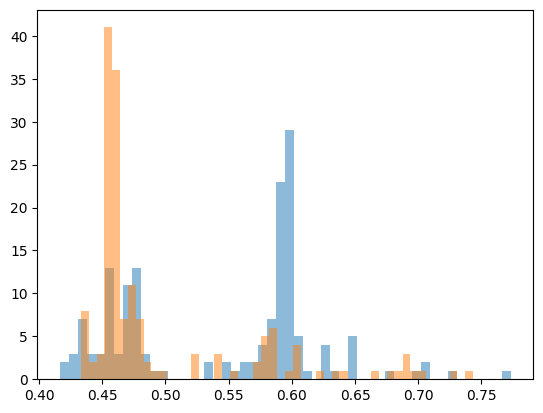

In [90]:
ce.boltzmann_statistic("buried_volume_H1") , ce.boltzmann_statistic("buried_volume_H2")

fig, ax = plt.subplots()    
ax.hist(ce.get_properties()["buried_volume_H1"], bins=50, alpha=0.5, label='H1')
ax.hist(ce.get_properties()["buried_volume_H2"], bins=50, alpha=0.5, label='H2')


In [57]:
from morfeus import BuriedVolume, read_xyz
import os
from photocat_database.calculators.Optimise_ON import ETKDG_constaint
db_mol = "constructed_photocat_E"
db_polymer = stk.ConstructedMoleculeMongoDb(
    client,
    database=db_mol,
)
constructed_molecule_E = db_polymer.get(
    {"InChIKey": inchikey_photo_cat_E}
)
mol = constructed_molecule_E.to_rdkit_mol()
display(mol)
xyz_file = client.constructed_photocat_E.XTB_opt.find_one({"InChIKey": inchikey_photo_cat_E})['cal_folder']+ "/xtbopt.xyz"
#constructed_molecule_E.with_structure_from_file(xyz_file)
constructed_molecule_E.write("constructed_photocat_E.xyz")
elements, coordinates = read_xyz("constructed_photocat_E.xyz")
calculator = ETKDG_constaint()
oxygen_id, hydrogen_id = calculator.get_atom_position_to_induce_constain_for_3bb(constructed_molecule_E)
bv = BuriedVolume(elements, coordinates, hydrogen_id[0]+1)
print(bv.fraction_buried_volume)
bv.print_report()
bv = BuriedVolume(elements, coordinates, hydrogen_id[1]+1)
print(bv.fraction_buried_volume)
bv.print_report()
import itertools
import numpy as np

distances = [ np.linalg.norm(coordinates[oxygen_i] - coordinates[hydrogen_i]) for oxygen_i, hydrogen_i in itertools.product(oxygen_id, hydrogen_id)]
print(distances)

NameError: name 'inchikey_photo_cat_E' is not defined